# Introduce the Problem
Charlotte isn't the same as it used to be, at least I don't think it is. Upon my arrival in 2004, what I once thought was sunshine and rainbows eventually faded into dust. The number of deplorable drivers that I've stumbled upon as of lately has made me appalled and confused. I find it adruous to continue my day as normal without having to witness some of Charlotte's worst drivers. My curiosity cries for an answer. In order to fulfill this request, I will attempt to determine whether this has always been a recurring issue and if anything is being done about it. Additionally, I would like to identify patterns and determine who is more suspectible than others by classifying data related to the driver.

# Introduce the Data
The dataset that I will be examining comes from no other than the Charlotte-Mecklenburg Police Department (CMPD). I was previously interested in another dataset that was derived from CMPD through Kaggle. However, because said dataset was merely a clone, I instead went directly to [data.charlottenc.gov](https://data.charlottenc.gov/), which was where this dataset was originally from. The current dataset involves traffic stops that were performed in Mecklenburg County, Charlotte, North Carolina, from 2015 through 2024. The features of this dataset include:

- OBJECTID
- Month_of_Stop
- Reason_for_Stop
- Officer_Race
- Officer_Gender
- Officer_Years_of_Service
- Driver_Race
- Driver_Ethnicity
- Driver_Gender
- Driver_Age
- Was_a_Search_Conducted
- Result_of_Stop
- CMPD_Division
- GlobalID

**NOTE:** Everything but OBJECTID, Month_of_Stop, and GlobalID, are self-explanatory. OBJECTID refers to the row index. In actuality, Month_of_Stop includes both the year and month. GlobalID is just a geographical reference that is added into the extracted dataset by ArcGIS Online.

# Pre-processing the Data
Unfortunately, pre-processing the data provided will be my first order of business, and there's a lot to clean. To keep things tidy, I'll go over my steps in a fasionably manner that is comprehenisble.

## Initialization
To get started, I will be installing the necessary libraries and setting up the environment. Be sure to read the comments within the code to understand what's happening!

In [5]:
!pip install pandas matplotlib

In [6]:
import pandas as pd

In [7]:
# We are now ready to examine the selected dataset.
traffic_stops_df = pd.read_csv('CMPD_Traffic_Stops.csv')
# Obtain and read the first 5 rows of the traffic stops.
traffic_stops_df.head()

,OBJECTID,Month_of_Stop,Reason_for_Stop,Officer_Race,Officer_Gender,Officer_Years_of_Service,Driver_Race,Driver_Ethnicity,Driver_Gender,Driver_Age,Was_a_Search_Conducted,Result_of_Stop,CMPD_Division,GlobalID
0,1,2019/11,Speeding,White,Male,12.0,Asian,Non-Hispanic,Female,39,NO,Citation Issued,South Division,{A45CF4CD-282F-4030-A160-72773A3B4730}
1,2,2019/11,Speeding,White,Male,21.0,White,Non-Hispanic,Female,24,NO,Citation Issued,Independence Division,{B03798C2-6FB5-4ED5-A15C-1BCBDA3C27D5}
2,3,2019/11,Speeding,Asian / Pacific Islander,Male,11.0,White,Non-Hispanic,Male,27,NO,Citation Issued,Independence Division,{AB78EFFB-CB43-4488-B244-6E845DB18222}
3,4,2019/11,Speeding,White,Male,13.0,Black,Non-Hispanic,Female,20,NO,Citation Issued,University City Division,{1BF01CA7-E08A-4C3A-8FDD-2EF1A1AEB2D0}
4,5,2019/11,Vehicle Regulatory,White,Male,22.0,White,Non-Hispanic,Female,33,NO,Citation Issued,Independence Division,{7EEB79D4-2FF9-48F7-AC4B-4FC5F8A13EF8}


In [8]:
# Rows x Columns (Total)
traffic_stops_df.shape

(809972, 14)

## Irrelevant Data
If you haven't already noticed, we have some columns, specifically OBJECTID and GlobalID, that don't serve any purpose under our circumstances. OBJECTID is redundant as we could utilize the indexes that Pandas already provides us. GlobalID renders useless because we aren't focused on mapping with ArcGIS Online. Therefore, both of these columns should be removed so that we only work with what we need.

In [10]:
traffic_stops_df = traffic_stops_df.drop(['OBJECTID', 'GlobalID'], axis=1)
traffic_stops_df.head()

,Month_of_Stop,Reason_for_Stop,Officer_Race,Officer_Gender,Officer_Years_of_Service,Driver_Race,Driver_Ethnicity,Driver_Gender,Driver_Age,Was_a_Search_Conducted,Result_of_Stop,CMPD_Division
0,2019/11,Speeding,White,Male,12.0,Asian,Non-Hispanic,Female,39,NO,Citation Issued,South Division
1,2019/11,Speeding,White,Male,21.0,White,Non-Hispanic,Female,24,NO,Citation Issued,Independence Division
2,2019/11,Speeding,Asian / Pacific Islander,Male,11.0,White,Non-Hispanic,Male,27,NO,Citation Issued,Independence Division
3,2019/11,Speeding,White,Male,13.0,Black,Non-Hispanic,Female,20,NO,Citation Issued,University City Division
4,2019/11,Vehicle Regulatory,White,Male,22.0,White,Non-Hispanic,Female,33,NO,Citation Issued,Independence Division


In [11]:
# There should be 12 columns!
traffic_stops_df.shape

(809972, 12)

## Missing Values
Nice, the columns were successfully dropped and we can now proceed further. Often times, data may have missing entries, which could negatively impact our data interpretation. Let's see if we can spot these outliers. 

In [13]:
# For each column, count the total number of missing entries.
traffic_stops_df.isna().sum()

Month_of_Stop                   0
Reason_for_Stop                 0
Officer_Race                    2
Officer_Gender                  2
Officer_Years_of_Service        2
Driver_Race                     0
Driver_Ethnicity                0
Driver_Gender                   0
Driver_Age                      0
Was_a_Search_Conducted          0
Result_of_Stop                  0
CMPD_Division               76770
dtype: int64

Depending on how you look at this, I'd say this is better than most datasets out there. We can simply remove the rows that include entries regarding the officer. The removal of these rows won't negatively impact our data in any way as it's less than 0.01% of our total data! However, dropping 76,770 rows that don't include a CMPD division can be detrimental to our analysis. It'd probably be safe to fill these missing entries as 'Unknown' for the time being.

**NOTE:** We can safely assume that the officer's with missing entries are related. Essentially, there should only be 2 rows that are removed becuase each officer column is equal to the other.

In [15]:
# Drop the rows that only have missing entries for officer columns. The subset implies strict rules so that we can avoid dropping the
# 76,770 rows related to CMPD division.
traffic_stops_df = traffic_stops_df.dropna(axis=0, subset=['Officer_Race', 'Officer_Gender', 'Officer_Years_of_Service'])
# Verify that all officer columns have no missing entries.
traffic_stops_df.isna().sum()

Month_of_Stop                   0
Reason_for_Stop                 0
Officer_Race                    0
Officer_Gender                  0
Officer_Years_of_Service        0
Driver_Race                     0
Driver_Ethnicity                0
Driver_Gender                   0
Driver_Age                      0
Was_a_Search_Conducted          0
Result_of_Stop                  0
CMPD_Division               76770
dtype: int64

In [16]:
# Let's see if our assumption was correct. If so, we should have only lost 2 rows... WE DID!
traffic_stops_df.shape

(809970, 12)

In [17]:
# Fill every missing CMPD_Division with 'Unknown'.
traffic_stops_df['CMPD_Division'] = traffic_stops_df['CMPD_Division'].fillna('Unknown')
# We should now have no missing entries!
traffic_stops_df.isna().sum()

Month_of_Stop               0
Reason_for_Stop             0
Officer_Race                0
Officer_Gender              0
Officer_Years_of_Service    0
Driver_Race                 0
Driver_Ethnicity            0
Driver_Gender               0
Driver_Age                  0
Was_a_Search_Conducted      0
Result_of_Stop              0
CMPD_Division               0
dtype: int64

In [18]:
# Verify that we have exactly 76,770 rows that have 'Unknown' CMPD_Division entries.
traffic_stops_df[traffic_stops_df['CMPD_Division'] == 'Unknown']

,Month_of_Stop,Reason_for_Stop,Officer_Race,Officer_Gender,Officer_Years_of_Service,Driver_Race,Driver_Ethnicity,Driver_Gender,Driver_Age,Was_a_Search_Conducted,Result_of_Stop,CMPD_Division
21,2019/11,Other,White,Male,4.0,White,Non-Hispanic,Female,27,NO,Verbal Warning,Unknown
28,2019/11,Speeding,Asian / Pacific Islander,Male,23.0,Black,Non-Hispanic,Male,40,NO,Citation Issued,Unknown
58,2019/11,Vehicle Regulatory,White,Male,4.0,White,Non-Hispanic,Male,39,NO,Verbal Warning,Unknown
60,2019/11,Vehicle Regulatory,White,Male,4.0,Black,Non-Hispanic,Male,33,NO,Citation Issued,Unknown
61,2019/11,Vehicle Regulatory,Asian / Pacific Islander,Male,9.0,Black,Non-Hispanic,Male,51,NO,Verbal Warning,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...
809897,2019/11,Vehicle Regulatory,White,Male,2.0,Black,Hispanic,Male,24,NO,Verbal Warning,Unknown
809914,2019/11,Vehicle Regulatory,White,Male,4.0,White,Non-Hispanic,Female,28,NO,Verbal Warning,Unknown
809916,2019/11,Stop Light/Sign,White,Male,14.0,White,Hispanic,Male,18,YES,Citation Issued,Unknown
809921,2019/11,Other,White,Male,4.0,Black,Non-Hispanic,Female,41,NO,Verbal Warning,Unknown


## Type Conversion
Manipulating the data provided can guide me towards answering my question. However, before I decide to manipulate data for analysis, it's integral that I see what I am working with prior to making changes.

In [20]:
traffic_stops_df.dtypes

Month_of_Stop                object
Reason_for_Stop              object
Officer_Race                 object
Officer_Gender               object
Officer_Years_of_Service    float64
Driver_Race                  object
Driver_Ethnicity             object
Driver_Gender                object
Driver_Age                    int64
Was_a_Search_Conducted       object
Result_of_Stop               object
CMPD_Division                object
dtype: object

I am not fond of Officer_Years_of_Service being a float64 data type because years should be integers and not rational numbers. Furthermore, to ensure data integrity, I would like to default the columns to their respective data types so that manipulating them won't become a hassle later down the road.

In [22]:
traffic_stops_df = traffic_stops_df.astype({
    'Month_of_Stop':str,
    'Reason_for_Stop':str,
    'Officer_Race':str,
    'Officer_Gender':str,
    'Officer_Years_of_Service':int,
    'Driver_Race':str,
    'Driver_Ethnicity':str,
    'Driver_Gender':str,
    'Driver_Age':int,
    'Was_a_Search_Conducted':str,
    'Result_of_Stop':str,
    'CMPD_Division':str
})
traffic_stops_df.dtypes

Month_of_Stop               object
Reason_for_Stop             object
Officer_Race                object
Officer_Gender              object
Officer_Years_of_Service     int32
Driver_Race                 object
Driver_Ethnicity            object
Driver_Gender               object
Driver_Age                   int32
Was_a_Search_Conducted      object
Result_of_Stop              object
CMPD_Division               object
dtype: object

## Syntax Errors
We're almost done! All that's left is the silly syntax error targeting a specific column. As already mentioned, Month_of_Stop includes not only the month, but the year too! Do not fret, since we can simply take the substring of Month_of_Stop to make proper columns, as follows:

In [24]:
traffic_stops_df['year_of_stop'] = traffic_stops_df['Month_of_Stop'].apply(lambda x: x[0:4])
traffic_stops_df['month_of_stop'] = traffic_stops_df['Month_of_Stop'].apply(lambda x: x[5:])

traffic_stops_df

,Month_of_Stop,Reason_for_Stop,Officer_Race,Officer_Gender,Officer_Years_of_Service,Driver_Race,Driver_Ethnicity,Driver_Gender,Driver_Age,Was_a_Search_Conducted,Result_of_Stop,CMPD_Division,year_of_stop,month_of_stop
0,2019/11,Speeding,White,Male,12,Asian,Non-Hispanic,Female,39,NO,Citation Issued,South Division,2019,11
1,2019/11,Speeding,White,Male,21,White,Non-Hispanic,Female,24,NO,Citation Issued,Independence Division,2019,11
2,2019/11,Speeding,Asian / Pacific Islander,Male,11,White,Non-Hispanic,Male,27,NO,Citation Issued,Independence Division,2019,11
3,2019/11,Speeding,White,Male,13,Black,Non-Hispanic,Female,20,NO,Citation Issued,University City Division,2019,11
4,2019/11,Vehicle Regulatory,White,Male,22,White,Non-Hispanic,Female,33,NO,Citation Issued,Independence Division,2019,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
809967,2019/11,Speeding,White,Female,13,Black,Non-Hispanic,Female,21,NO,Citation Issued,Metro Division,2019,11
809968,2019/11,Vehicle Regulatory,White,Male,19,Black,Non-Hispanic,Male,39,NO,Citation Issued,Freedom Division,2019,11
809969,2019/11,Speeding,Black/African American,Male,10,White,Non-Hispanic,Male,45,NO,Citation Issued,North Division,2019,11
809970,2019/11,Speeding,Black/African American,Male,10,Black,Non-Hispanic,Male,30,NO,Citation Issued,North Division,2019,11


Be careful! Our newly created columns are of type object. Instead, we should explicitly make these data types int32. Let's change that real quick...

In [26]:
traffic_stops_df.dtypes

Month_of_Stop               object
Reason_for_Stop             object
Officer_Race                object
Officer_Gender              object
Officer_Years_of_Service     int32
Driver_Race                 object
Driver_Ethnicity            object
Driver_Gender               object
Driver_Age                   int32
Was_a_Search_Conducted      object
Result_of_Stop              object
CMPD_Division               object
year_of_stop                object
month_of_stop               object
dtype: object

In [27]:
traffic_stops_df = traffic_stops_df.astype({
    'year_of_stop':int,
    'month_of_stop':int
})

traffic_stops_df.dtypes

Month_of_Stop               object
Reason_for_Stop             object
Officer_Race                object
Officer_Gender              object
Officer_Years_of_Service     int32
Driver_Race                 object
Driver_Ethnicity            object
Driver_Gender               object
Driver_Age                   int32
Was_a_Search_Conducted      object
Result_of_Stop              object
CMPD_Division               object
year_of_stop                 int32
month_of_stop                int32
dtype: object

Great, our data is now ready to be analyzed! All that is left is removing Month_of_Stop since we no longer need it.

In [29]:
traffic_stops_df = traffic_stops_df.drop(['Month_of_Stop'], axis=1)
traffic_stops_df

,Reason_for_Stop,Officer_Race,Officer_Gender,Officer_Years_of_Service,Driver_Race,Driver_Ethnicity,Driver_Gender,Driver_Age,Was_a_Search_Conducted,Result_of_Stop,CMPD_Division,year_of_stop,month_of_stop
0,Speeding,White,Male,12,Asian,Non-Hispanic,Female,39,NO,Citation Issued,South Division,2019,11
1,Speeding,White,Male,21,White,Non-Hispanic,Female,24,NO,Citation Issued,Independence Division,2019,11
2,Speeding,Asian / Pacific Islander,Male,11,White,Non-Hispanic,Male,27,NO,Citation Issued,Independence Division,2019,11
3,Speeding,White,Male,13,Black,Non-Hispanic,Female,20,NO,Citation Issued,University City Division,2019,11
4,Vehicle Regulatory,White,Male,22,White,Non-Hispanic,Female,33,NO,Citation Issued,Independence Division,2019,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
809967,Speeding,White,Female,13,Black,Non-Hispanic,Female,21,NO,Citation Issued,Metro Division,2019,11
809968,Vehicle Regulatory,White,Male,19,Black,Non-Hispanic,Male,39,NO,Citation Issued,Freedom Division,2019,11
809969,Speeding,Black/African American,Male,10,White,Non-Hispanic,Male,45,NO,Citation Issued,North Division,2019,11
809970,Speeding,Black/African American,Male,10,Black,Non-Hispanic,Male,30,NO,Citation Issued,North Division,2019,11


## Additionals
The data is now properly cleansed and we may continue forward towards interpretating our data. However, it wouldn't hurt to implement additional features into our dataset to further expand our analysis. 

### season_of_stop
A column that provides the user which season the traffic stop occured in.

In [32]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    return 'Autumn'

traffic_stops_df['season_of_stop'] = traffic_stops_df['month_of_stop'].apply(get_season)
traffic_stops_df

,Reason_for_Stop,Officer_Race,Officer_Gender,Officer_Years_of_Service,Driver_Race,Driver_Ethnicity,Driver_Gender,Driver_Age,Was_a_Search_Conducted,Result_of_Stop,CMPD_Division,year_of_stop,month_of_stop,season_of_stop
0,Speeding,White,Male,12,Asian,Non-Hispanic,Female,39,NO,Citation Issued,South Division,2019,11,Autumn
1,Speeding,White,Male,21,White,Non-Hispanic,Female,24,NO,Citation Issued,Independence Division,2019,11,Autumn
2,Speeding,Asian / Pacific Islander,Male,11,White,Non-Hispanic,Male,27,NO,Citation Issued,Independence Division,2019,11,Autumn
3,Speeding,White,Male,13,Black,Non-Hispanic,Female,20,NO,Citation Issued,University City Division,2019,11,Autumn
4,Vehicle Regulatory,White,Male,22,White,Non-Hispanic,Female,33,NO,Citation Issued,Independence Division,2019,11,Autumn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
809967,Speeding,White,Female,13,Black,Non-Hispanic,Female,21,NO,Citation Issued,Metro Division,2019,11,Autumn
809968,Vehicle Regulatory,White,Male,19,Black,Non-Hispanic,Male,39,NO,Citation Issued,Freedom Division,2019,11,Autumn
809969,Speeding,Black/African American,Male,10,White,Non-Hispanic,Male,45,NO,Citation Issued,North Division,2019,11,Autumn
809970,Speeding,Black/African American,Male,10,Black,Non-Hispanic,Male,30,NO,Citation Issued,North Division,2019,11,Autumn


### driver_age_group
A column that classifies the driver's age into groups.

In [34]:
def get_age_group(age):
    if age > 45:
        return 'Old-aged Adult'
    elif age >= 31 and age <= 45:
        return 'Middle-aged Adult'
    elif age >= 17 and age <= 30:
        return 'Young Adult'
    return 'Child'

traffic_stops_df['driver_age_group'] = traffic_stops_df['Driver_Age'].apply(get_age_group)
traffic_stops_df

,Reason_for_Stop,Officer_Race,Officer_Gender,Officer_Years_of_Service,Driver_Race,Driver_Ethnicity,Driver_Gender,Driver_Age,Was_a_Search_Conducted,Result_of_Stop,CMPD_Division,year_of_stop,month_of_stop,season_of_stop,driver_age_group
0,Speeding,White,Male,12,Asian,Non-Hispanic,Female,39,NO,Citation Issued,South Division,2019,11,Autumn,Middle-aged Adult
1,Speeding,White,Male,21,White,Non-Hispanic,Female,24,NO,Citation Issued,Independence Division,2019,11,Autumn,Young Adult
2,Speeding,Asian / Pacific Islander,Male,11,White,Non-Hispanic,Male,27,NO,Citation Issued,Independence Division,2019,11,Autumn,Young Adult
3,Speeding,White,Male,13,Black,Non-Hispanic,Female,20,NO,Citation Issued,University City Division,2019,11,Autumn,Young Adult
4,Vehicle Regulatory,White,Male,22,White,Non-Hispanic,Female,33,NO,Citation Issued,Independence Division,2019,11,Autumn,Middle-aged Adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
809967,Speeding,White,Female,13,Black,Non-Hispanic,Female,21,NO,Citation Issued,Metro Division,2019,11,Autumn,Young Adult
809968,Vehicle Regulatory,White,Male,19,Black,Non-Hispanic,Male,39,NO,Citation Issued,Freedom Division,2019,11,Autumn,Middle-aged Adult
809969,Speeding,Black/African American,Male,10,White,Non-Hispanic,Male,45,NO,Citation Issued,North Division,2019,11,Autumn,Middle-aged Adult
809970,Speeding,Black/African American,Male,10,Black,Non-Hispanic,Male,30,NO,Citation Issued,North Division,2019,11,Autumn,Young Adult


# Data Understanding/Visualization

In [ ]:
import matplotlib.pyplot as plt

## Reccuring Trend

Text(0, 0.5, 'Traffic Stops')

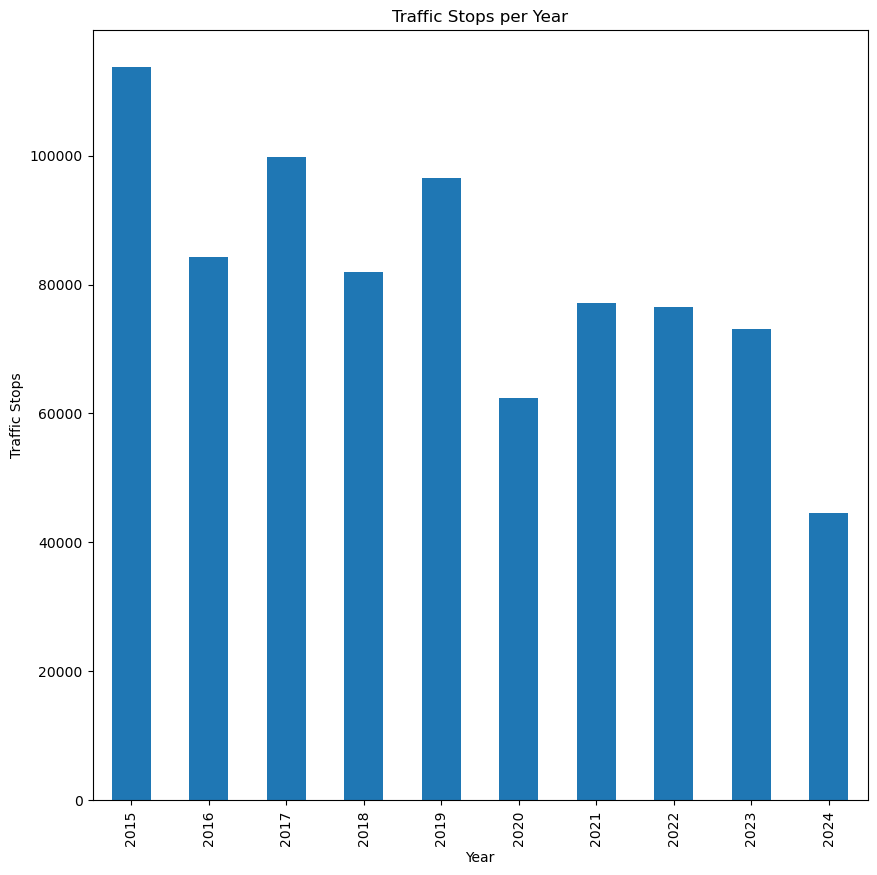

In [95]:
traffic_stops_per_year = traffic_stops_df['year_of_stop'].value_counts()
traffic_stops_per_year = traffic_stops_per_year.sort_index()

plt.figure(figsize=(10, 10))

traffic_stops_per_year.plot(kind='bar')

plt.title('Traffic Stops per Year')
plt.xlabel('Year')
plt.ylabel('Traffic Stops')

# Storytelling
## Recurring Trend
Based on the bar graph, we can observe that CMPD's efforts in conducting traffic stops have significantly decreased. In fact, the graph reveals a sharp decline in traffic stops over the observed period, indicating a noticeable reduction in enforcement activity.